### Bistable wilson and cowan like model

from : https://elifesciences.org/articles/22425#fig5

In [2]:
# for fast array manipulation
import numpy as np
# for plotting
import matplotlib.pyplot as plt
# for numerical ODE integration
from scipy.integrate import solve_ivp
# to display plots in-line
%matplotlib inline
plt.style.use('ggplot')

In [3]:
def sigmoid(x, a, thr):
    return 1 / (1 + np.exp(-a * (x - thr)))

def threshold_linear(x,thr,gain):
    thresholded = x-thr
    if thresholded > 0:
        return gain*thresholded
    else:
        return 0 

vthreshold_linear = np.vectorize(threshold_linear)

In [4]:
# Time constant of neural pop in seconds
tau_e = 0.010
tau_i = 0.002
tau_a = 0.5
# Synapse strength
j_ee = 5
j_ei = 1
j_ie = 10
j_iwe = 5
j_ii = 0.5
j_rec = 1.5
# Adaptation parameter
beta = 6
tau_a = 0.5
# threshold and gains
g_e = 1
g_i = 4
thr_i = 25
thr_e = 3 # to play with
# Input currents
I_e = 6
# I_e-thr_e = 3 which is equivalent to taking I_e = 0 and thr_e = -3 as in the paper 
plas_ie = 0.1
plas_iwe = 0.1
plas_ei = 0.3
plas_eiw = 0.3
exc_increase = 0.003
inhib_decay = 0.03
target_inhib = 8
target_inhib_wide = target_inhib
target_exc = 4
target_total_exc = 4.1

# Network structure parameters

nb_per_pool = 2

In [5]:
# this function returns the right hand side of the Wilson-Cowan equation
# (both, in a 2-vector)
def rate_model(t,y ,nb_per_pool):
    
    # data structure  :
    # output_pool[x,0] = E
    # output_pool[x,1] = I
    # output_pool[x,2] = A
    # output_pool[x,3] = J_ie
    # output_pool[x,4] = J_ei
    # output_pool[x,5] = J_eiw
    # output_pool[x,6] = J_iwe
    # large_inib : the activity of the long range inhibitory unit inducing competition

    output_pools = np.array(nb_per_pool,7)

    large_inhib = 0

    for n in nb_per_pool:

    E = y[0]
    E2 = y[1]
    I = y[2]
    I2 = y[3]
    I3 = y[4]
    A = y[5]
    A2 = y[6]
    J_ie = y[7] 
    J_i2e2 = y[8]
    J_i3e = y[9]
    J_i3e2 = y[10]
    J_ei = y[11]
    J_e2i2 = y[12]
    J_ei3 = y[13]
    J_e2i3 = y[14]

    y1 = (-E + vthreshold_linear(j_rec*E2+j_ee*E-J_ei3*I3-J_ei*I-A+I_e,thr_e, g_e))/tau_e
    y2 = (-E2 + vthreshold_linear(j_rec*E+j_ee*E2-J_e2i3*I3-J_e2i2*I2-A2+I_e, thr_e, g_e))/tau_e
    y3 = (-I + vthreshold_linear(J_ie*E-j_ii*I,thr_i,g_i))/tau_i
    y4 = (-I2 + vthreshold_linear(J_i2e2*E2-j_ii*I2,thr_i,g_i))/tau_i
    y5 = (-I3 + vthreshold_linear(J_i3e*E+J_i3e2*E2-j_ii*I3,thr_i,g_i))/tau_i
    y6 = (-A + beta*E)/tau_a
    y7 = (-A2 + beta*E2)/tau_a

    #Synaptic plasticity

    if J_ie<0:
        y8 = -J_ie
    else : 
        y8 = -(((I-target_inhib)>0)*E*plas_ie)+exc_increase

    if J_i2e2<0:
        y9 = -J_i2e2
    else : 
        y9 = -(((I2-target_inhib)>0)*E2*plas_ie)+exc_increase
    
    if J_i3e<0 :
        y10 = -J_i3e
    else :
        y10 = -(((I3-target_inhib_wide)>0)*E*plas_iwe)+exc_increase
    
    if J_i3e2<0 :
        y11 = -J_i3e2
    else :
        y11 = -(((I3-target_inhib_wide)>0)*E2*plas_iwe)+exc_increase

    if J_ei<0:
        y12 = -J_ei
    else : 
        y12 = (((E-target_exc)>0)*I*plas_ei)-inhib_decay

    if J_e2i2<0:
        y13 = -J_e2i2
    else : 
        y13 = (((E2-target_exc)>0)*I2*plas_ei)-inhib_decay
    
    if J_ei3<0:
        y14 = -J_ei3
    else : 
        y14 = (((E+E2-target_total_exc)>0)*I3*plas_eiw)-inhib_decay
    
    if J_e2i3<0:
        y15 = -J_e2i3
    else : 
        y15 = (((E+E2-target_total_exc)>0)*I3*plas_eiw)-inhib_decay

    return [y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15]


In [6]:
solve_ivp?

Signature:
solve_ivp(
    fun,
    t_span,
    y0,
    method='RK45',
    t_eval=None,
    dense_output=False,
    events=None,
    vectorized=False,
    args=None,
    **options,
)
Docstring:
Solve an initial value problem for a system of ODEs.

This function numerically integrates a system of ordinary differential
equations given an initial value::

    dy / dt = f(t, y)
    y(t0) = y0

Here t is a 1-D independent variable (time), y(t) is an
N-D vector-valued function (state), and an N-D
vector-valued function f(t, y) determines the differential equations.
The goal is to find y(t) approximately satisfying the differential
equations, given an initial value y(t0)=y0.

Some of the solvers support integration in the complex domain, but note
that for stiff ODE solvers, the right-hand side must be
complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
To solve a problem in the complex domain, pass y0 with a complex data type.
Another option always available is to rewrite your pro

In [75]:
# simulation duration and step size
#time = np.linspace(0, 750, 40000)

# starting point, hopefully inside the basin of attraction of our attractor
E0, E20, I0, I20, I30, A0, A20, J_ie0, J_i2e20, J_i3e0, J_i3e20, J_ei0, J_e2i20, J_ei30, J_e2i30   = 0, 0, 0, 0, 0, 0, 1, j_ie, j_ie, j_iwe, j_iwe, j_ei, j_ei, j_ei, j_ei  # try changing this

# find the solution with scint.odeint
odesol = solve_ivp(rate_model,[0,1200], [E0, E20, I0, I20, I30, A0, A20, J_ie0, J_i2e20, J_i3e0, J_i3e20, J_ei0, J_e2i20, J_ei30, J_e2i30])

# separate the two solutions
exc_ts, exc2_ts, inh_ts,inh2_ts,inh3_ts, a_ts, a2_ts, j_ie_ts,j_i2e2_ts,j_i3e_ts,j_i3e2_ts,j_ei_ts,j_e2i2_ts,j_ei3_ts,j_e2i3_ts = odesol.y

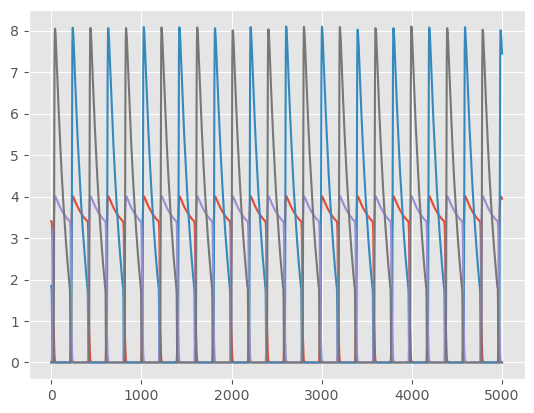

In [84]:
plt.plot(exc_ts[-5000:])
plt.plot(inh_ts[-5000:])
plt.plot(exc2_ts[-5000:])
plt.plot(inh2_ts[-5000:])

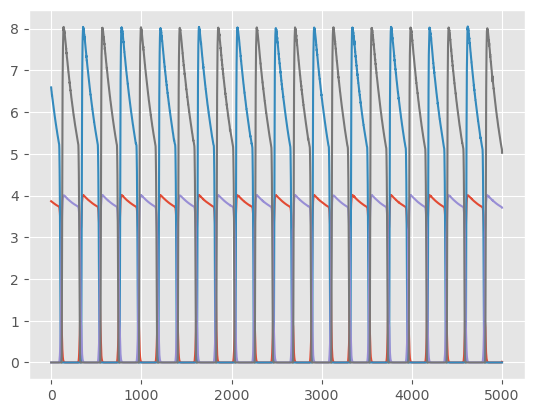

In [77]:
plt.plot(exc_ts[350000:355000])
plt.plot(inh_ts[350000:355000])
plt.plot(exc2_ts[350000:355000])
plt.plot(inh2_ts[350000:355000])

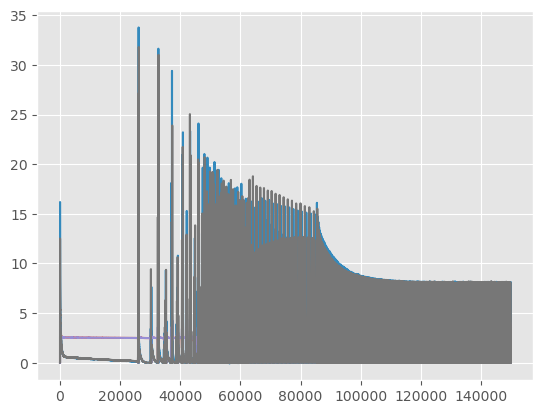

In [78]:
plt.plot(exc_ts[:150000])
plt.plot(inh_ts[:150000])
plt.plot(exc2_ts[:150000])
plt.plot(inh2_ts[:150000])

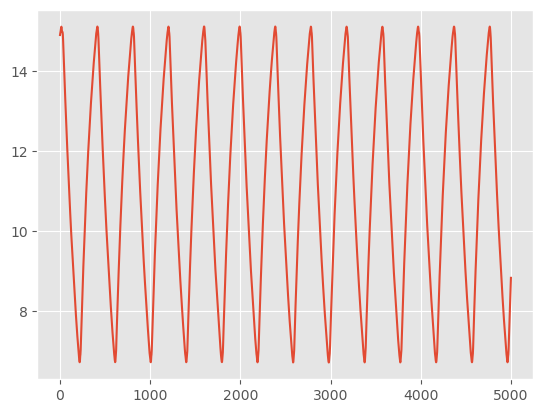

In [79]:
plt.plot(a_ts[-5000:]);

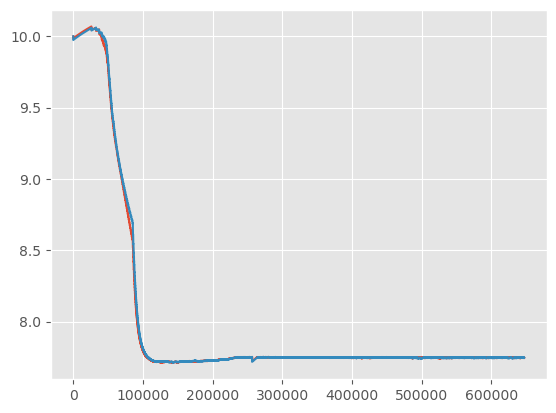

In [80]:
plt.plot(j_i2e2_ts);
plt.plot(j_ie_ts);
#plt.plot(inh_ts[-5000:]);

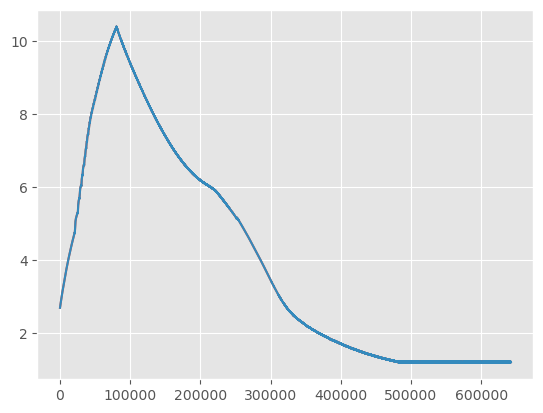

In [87]:
plt.plot(j_e2i3_ts[5000:]);
plt.plot(j_ei3_ts[5000:]);

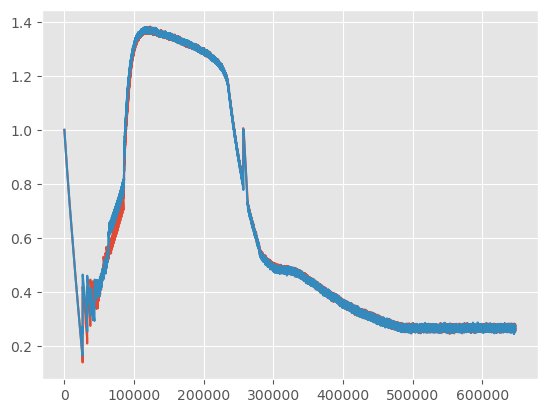

In [82]:
plt.plot(j_ei_ts);
plt.plot(j_e2i2_ts);

In [83]:
# # plotting the vector field in the state space (E, I)
# plt.figure(figsize=(10, 10))
# #plt.quiver(x2[:,:,49], x1[:,:,49], X2[:,:,49], X1[:,:,49], pivot='mid', alpha=.5)
# plt.xlim([minval, maxval])
# plt.ylim([minval, maxval])
# plt.xlabel(r'$I$', fontsize=16) # yes, you can use Latex code!
# plt.ylabel(r'$E$', fontsize=16)
# plt.grid()

# # plot the solution in the state space
# plt.plot(inh_timeseries, exc_timeseries, '.-');

# # plot the fixed points we identified
# plt.scatter(fixed_p[1], fixed_p[0], marker='o', c='k', s=50,
#             label="Stationary points")

# # plot the starting point
# plt.scatter(I0, E0, marker='*', c='r', s=300, label="Starting point")
# plt.legend(loc="upper left")

# # plot the solution in time
# plt.figure(figsize=(10.3,3))
# plt.ylabel(r'$E, I$')
# plt.xlabel(r'$t$')
# plt.plot(time, exc_timeseries, '.-', label="excitatory");
# plt.plot(time, inh_timeseries, '.-', label="inhibitory");
# plt.legend();